# Projet Machine Learning : Détection de Surcharge et de Surmenage

## Problématique

**Peut-on prédire les jours où mon corps est en état de fatigue excessive à partir des données de charge d’entraînement et de récupération fournies par ma montre Garmin ?**

## Structure du Notebook

Le projet sera organisé en deux grandes sections principales dans le notebook :

### 1. Formalisation du Problème

Cette section pose le cadre théorique et la définition du problème de classification à résoudre.

### 2. Pipeline Machine Learning

Cette section couvrira les étapes pratiques, de l'acquisition des données à la sélection du modèle.

* **Récupération et Analyse des Données**
    * Récupération des données depuis l'API de Garmin.
    * Analyse des données.
    * Statistiques descriptives des données récupérées.
    * Visualisation des distributions des données clés (stress, sommeil, pas).
    * Corrélation entre les variables.
* **Préparation des Données**
    * Nettoyage des données (gestion des valeurs manquantes, des erreurs, etc.).
    * Sélection des variables utiles (sélection de caractéristiques).
    * Fusion (*merging*) des fichiers CSV récupérés (données physiologiques et activités).
    * Construction de la **variable cible** $\text{overtraining\_risk}$ (heuristique).
* **Sélection d'un Modèle de Base**
    * Définition de la métrique de performance.
    * Entraînement et évaluation d'un premier modèle de classification (modèle de référence).

# 1. Formalisation du Problème

## Objectif

L’objectif de ce projet est de **détecter automatiquement les situations de surmenage** chez un individu à partir de **données physiologiques et comportementales** issues d’une montre connectée Garmin.

Pour ce faire, j’utiliserai les données collectées via ma propre montre Garmin, que je porte depuis environ deux ans, de manière quasi quotidienne :
* lors de mes différents **entraînements sportifs** (course à pied, vélo, natation, marche),
* mais aussi au cours de mes **journées classiques**.


## Définition du Surmenage

Le **surmenage** (ou *overtraining*) survient lorsque la **charge d’entraînement devient excessive** et que la **récupération n’est pas optimale**.

Cela se traduit généralement par :
* une **baisse des performances**,
* une **augmentation du risque de blessure**,
* et une **fatigue chronique** plus marquée.


## Données d’Entrée

Les données ont été extraites depuis mon compte Garmin, sous la forme de deux tableaux distincts (quotidien et activités), comportant diverses variables explicatives.

### 1. Données Physiologiques (Suivi Quotidien)

Ce premier tableau regroupe un résumé quotidien de plusieurs métriques physiologiques (quelques variables clés sont mises en évidence) :

> userProfileId, displayName, totalKilocalories, activeKilocalories, bmrKilocalories, wellnessKilocalories, burnedKilocalories, consumedKilocalories, remainingKilocalories, totalSteps, netCalorieGoal, totalDistanceMeters, wellnessDistanceMeters, wellnessActiveKilocalories, netRemainingKilocalories, userDailySummaryId, calendarDate, rule, uuid, dailyStepGoal, wellnessStartTimeGmt, wellnessStartTimeLocal, wellnessEndTimeGmt, wellnessEndTimeLocal, durationInMilliseconds, wellnessDescription, highlyActiveSeconds, activeSeconds, sedentarySeconds, sleepingSeconds, includesWellnessData, includesActivityData, includesCalorieConsumedData, privacyProtected, moderateIntensityMinutes, vigorousIntensityMinutes, floorsAscendedInMeters, floorsDescendedInMeters, floorsAscended, floorsDescended, intensityMinutesGoal, userFloorsAscendedGoal, **minHeartRate**, **maxHeartRate**, **restingHeartRate**, **lastSevenDaysAvgRestingHeartRate**, source, **averageStressLevel**, **maxStressLevel**, stressDuration, restStressDuration, activityStressDuration, uncategorizedStressDuration, totalStressDuration, lowStressDuration, mediumStressDuration, highStressDuration, stressPercentage, restStressPercentage, activityStressPercentage, uncategorizedStressPercentage, lowStressPercentage, mediumStressPercentage, highStressPercentage, stressQualifier, measurableAwakeDuration, measurableAsleepDuration, lastSyncTimestampGMT, minAvgHeartRate, maxAvgHeartRate, **bodyBatteryChargedValue**, **bodyBatteryDrainedValue**, **bodyBatteryHighestValue**, **bodyBatteryLowestValue**, **bodyBatteryMostRecentValue**, **bodyBatteryDuringSleep**, **bodyBatteryAtWakeTime**, bodyBatteryVersion, abnormalHeartRateAlertsCount, **averageSpo2**, **lowestSpo2**, **latestSpo2**, latestSpo2ReadingTimeGmt, latestSpo2ReadingTimeLocal, averageMonitoringEnvironmentAltitude, restingCaloriesFromActivity, **avgWakingRespirationValue**, **highestRespirationValue**, **lowestRespirationValue**, **latestRespirationValue**, latestRespirationTimeGMT, rule.typeId, rule.typeKey, respirationAlgorithmVersion, **hrvValue**, **sleepHours**, **stressLevel**, **steps**

### 2. Données d’Activité (Issues des Séances Enregistrées)

Ce second tableau correspond aux activités sportives enregistrées :

> activityId, activityName, **activityType**, **startTimeLocal**, **distance**, **duration**, **averageHR**, **maxHR**

## Variable Cible (Output)

La variable cible à prédire est : $\text{overtraining\_risk}$ (indicateur binaire de surmenage).

| Valeur | Interprétation |
| :---: | :--- |
| **0** | **Pas de surmenage** (récupération suffisante, charge modérée) |
| **1** | **Risque de surmenage** (fatigue, manque de récupération, stress élevé) |


## Type de Problème

Il s’agit d’un problème de **classification supervisée binaire** :

prédire un état de surmenage (oui/non) à partir de variables continues et catégorielles.

**Formellement :**

$$\mathbf{f}(\mathbf{X}) = \text{overtraining\_risk} \in \{0, 1\}$$

où $\mathbf{X}$ est le vecteur des variables d'entrée (e.g., $\text{RHR}$ - *Resting Heart Rate*, $\text{HRV}$ - *Heart Rate Variability*, $\text{Sleep}$, $\text{Stress}$, $\text{Distance}$, $\text{Duration}$, $\text{HR}$).


## Limite

En l’absence de mesure réelle et labellisée du surmenage, une **variable cible artificielle** a été construite à partir de règles heuristiques (stress élevé, faible sommeil, nombre élevé d’activités, etc.).

Cette variable ne reflète **pas un diagnostic réel**, mais permet de **tester la faisabilité** d’un modèle de détection sur ces données.

# 2. Pipeline Machine Learning
## Récupération et Analyse des Données

Récupération des données depuis l'API de Garmin.

In [3]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
from garminconnect import Garmin
import getpass

email = "antoine.deurv@gmail.com"
password = "Pinpindu92!+garmin"

client = Garmin(email, password)
client.login()

START_DATE = date(2024, 1, 1)
END_DATE = date.today()

activities = client.get_activities(0, 1000)
df_activities = pd.json_normalize(activities)
cols = ["activityId", "activityName", "activityType.typeKey", "startTimeLocal", "distance", "duration", "averageHR", "maxHR"]
df_activities = df_activities[[c for c in cols if c in df_activities.columns]].rename(columns={"activityType.typeKey": "activityType"})
df_activities.to_csv("data/garmin_activities.csv", index=False)

metrics = []
for i in range((END_DATE - START_DATE).days + 1):
    d = START_DATE + timedelta(days=i)
    try:
        s = client.get_stats(d.isoformat()) or {}
        s["calendarDate"] = s.get("calendarDate", d.isoformat())
        metrics.append(s)
    except:
        metrics.append({"calendarDate": d.isoformat()})
df_metrics = pd.json_normalize(metrics)

df_metrics["calendarDate"] = pd.to_datetime(df_metrics.get("calendarDate", pd.date_range(start=START_DATE, periods=len(df_metrics))))
def coalesce(df, name, candidates):
    for c in candidates:
        if c in df.columns:
            df[name] = df[c]
            return
    df[name] = np.nan
coalesce(df_metrics, "restingHeartRate", ["restingHeartRate", "restingHeartRateInBeatsPerMinute", "restingHR"])
coalesce(df_metrics, "hrvValue", ["hrvValue", "heartRateVariability.rmssd"])
sleep_col = next((c for c in df_metrics.columns if "sleep" in c.lower() and np.issubdtype(df_metrics[c].dtype, np.number)), None)
df_metrics["sleepHours"] = df_metrics[sleep_col] / 3600 if sleep_col else np.nan
coalesce(df_metrics, "stressLevel", ["stressLevel", "dailyStressLevel"])
coalesce(df_metrics, "steps", ["steps", "dailySteps", "stepCount"])

df_metrics = df_metrics.sort_values("calendarDate").reset_index(drop=True)
df_metrics.to_csv("data/garmin_daily_metrics.csv", index=False)
print(df_metrics[["calendarDate", "restingHeartRate", "hrvValue", "sleepHours", "stressLevel", "steps"]].head())

  calendarDate  restingHeartRate  hrvValue  sleepHours  stressLevel  steps
0   2024-01-01               NaN       NaN         NaN          NaN    NaN
1   2024-01-02               NaN       NaN         NaN          NaN    NaN
2   2024-01-03               NaN       NaN         NaN          NaN    NaN
3   2024-01-04               NaN       NaN         NaN          NaN    NaN
4   2024-01-05               NaN       NaN         NaN          NaN    NaN


Analyse générale des données.

In [6]:
import pandas as pd

# Chargement des fichiers
daily = pd.read_csv("data/garmin_daily_metrics.csv", sep=";")
activities = pd.read_csv("data/garmin_activities.csv", sep=";")

# Vue générale
print("Shape daily :", daily.shape)
print("Shape activities :", activities.shape)

# Colonnes disponibles
print("Colonnes daily :", daily.columns.tolist())
print("Colonnes activities :", activities.columns.tolist())

# Statistiques descriptives des variables principales
print(daily[["restingHeartRate", "sleepHours", "steps", "averageStressLevel", "totalKilocalories"]].describe())
print(activities[["distance", "duration", "averageHR", "maxHR"]].describe())

Shape daily : (631, 98)
Shape activities : (341, 8)
Colonnes daily : ['userProfileId', 'displayName', 'totalKilocalories', 'activeKilocalories', 'bmrKilocalories', 'wellnessKilocalories', 'burnedKilocalories', 'consumedKilocalories', 'remainingKilocalories', 'totalSteps', 'netCalorieGoal', 'totalDistanceMeters', 'wellnessDistanceMeters', 'wellnessActiveKilocalories', 'netRemainingKilocalories', 'userDailySummaryId', 'calendarDate', 'rule', 'uuid', 'dailyStepGoal', 'wellnessStartTimeGmt', 'wellnessStartTimeLocal', 'wellnessEndTimeGmt', 'wellnessEndTimeLocal', 'durationInMilliseconds', 'wellnessDescription', 'highlyActiveSeconds', 'activeSeconds', 'sedentarySeconds', 'sleepingSeconds', 'includesWellnessData', 'includesActivityData', 'includesCalorieConsumedData', 'privacyProtected', 'moderateIntensityMinutes', 'vigorousIntensityMinutes', 'floorsAscendedInMeters', 'floorsDescendedInMeters', 'floorsAscended', 'floorsDescended', 'intensityMinutesGoal', 'userFloorsAscendedGoal', 'minHeartRat

Statistiques descriptives des données récupérées.

In [7]:
# Statistiques principales pour les variables physiologiques et d'activité
desc_daily = daily[["restingHeartRate", "sleepHours", 
                          "averageStressLevel", "totalKilocalories", "activeKilocalories", "totalSteps"]].describe()
desc_activities = activities[["distance", "duration", "averageHR", "maxHR"]].describe()

print("=== Statistiques quotidiennes ===")
print(desc_daily)
print("\n=== Statistiques des activités ===")
print(desc_activities)

=== Statistiques quotidiennes ===
       restingHeartRate  sleepHours  averageStressLevel  totalKilocalories  \
count        573.000000  618.000000          616.000000         618.000000   
mean          53.565445    3.559140           32.133117        3027.668285   
std            7.651591    3.644783           14.879849         777.557147   
min           42.000000    0.000000           -2.000000         550.000000   
25%           49.000000    0.000000           23.750000        2478.000000   
50%           52.000000    1.566667           30.000000        2871.500000   
75%           57.000000    7.116667           40.000000        3406.000000   
max          132.000000   10.983333           93.000000        7018.000000   

       activeKilocalories    totalSteps  
count          618.000000    581.000000  
mean           831.804207  10901.857143  
std            746.006975   7152.319993  
min              0.000000      0.000000  
25%            253.500000   6230.000000  
50%        

In [8]:
# Conversion de startTimeLocal en datetime
activities["startTimeLocal"] = pd.to_datetime(activities["startTimeLocal"], errors="coerce", dayfirst=True)

# Extraire seulement la date
activities["activityDate"] = activities["startTimeLocal"].dt.date

# Nombre de jours avec au moins une activité
daily_activities_count = activities.groupby("activityDate").size()
print("Nombre de jours avec activité :", len(daily_activities_count))

# Nombre de jours sans activité
print("Nombre de jours sans activité :", len(daily) - len(daily_activities_count))

Nombre de jours avec activité : 280
Nombre de jours sans activité : 351


/var/folders/qs/y832lt_s6qj7xy_xnxzq26hc0000gn/T/ipykernel_7805/193708122.py:2: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  activities["startTimeLocal"] = pd.to_datetime(activities["startTimeLocal"], errors="coerce", dayfirst=True)


Visualisation des distributions des données clés (stress, sommeil, pas).

_note : on verra que dans les differentes distribution nous avons beaucoup de 0 car ce sont les moments ou je n'ai pas porté ma montre, par soucis de confort. On note ca notement sur les heures de sommeil_

1. Stress 

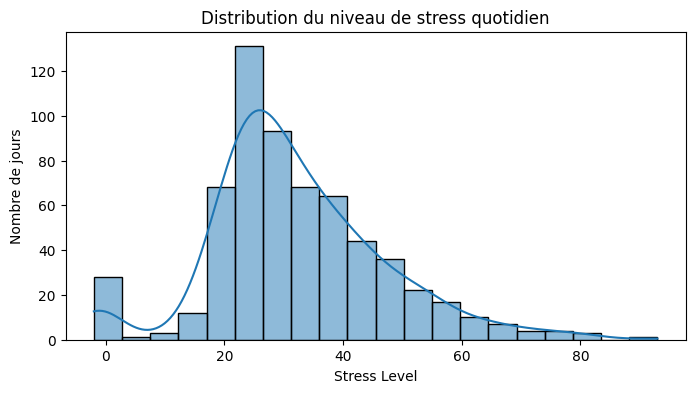

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(daily["averageStressLevel"], bins=20, kde=True)
plt.title("Distribution du niveau de stress quotidien")
plt.xlabel("Stress Level")
plt.ylabel("Nombre de jours")
plt.show()

2. Distribution du sommeil

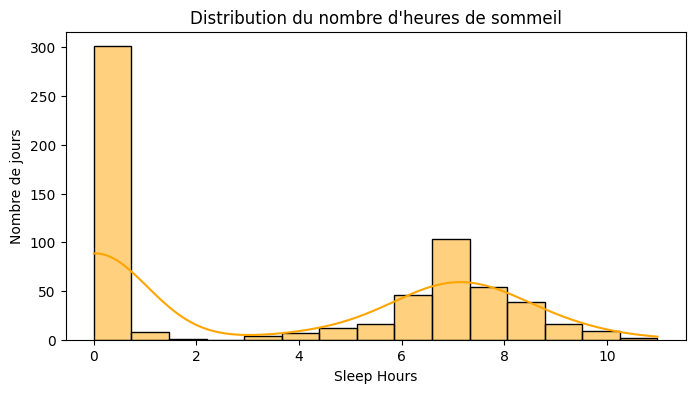

In [10]:
plt.figure(figsize=(8,4))
sns.histplot(daily["sleepHours"].dropna(), bins=15, kde=True, color="orange")
plt.title("Distribution du nombre d'heures de sommeil")
plt.xlabel("Sleep Hours")
plt.ylabel("Nombre de jours")
plt.show()

3. Distribution du nomnbres de pas

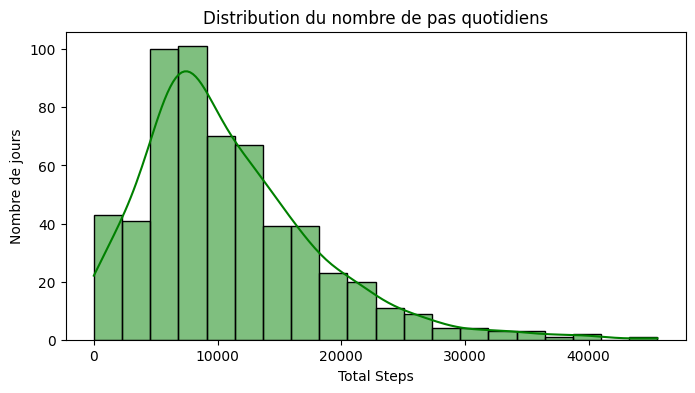

In [11]:
plt.figure(figsize=(8,4))
sns.histplot(daily["totalSteps"].dropna(), bins=20, kde=True, color="green")
plt.title("Distribution du nombre de pas quotidiens")
plt.xlabel("Total Steps")
plt.ylabel("Nombre de jours")
plt.show()

Corrélation entre les variables

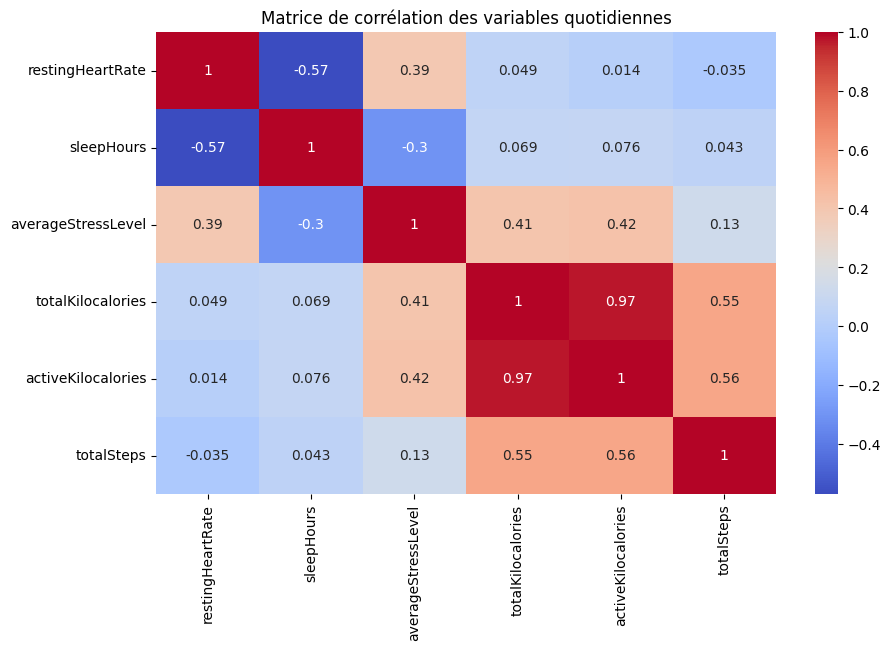

In [12]:
plt.figure(figsize=(10,6))
corr = daily[["restingHeartRate", "sleepHours", "averageStressLevel", "totalKilocalories", "activeKilocalories", "totalSteps"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation des variables quotidiennes")
plt.show()


## Préparation des Données
Nettoyage des données (gestion des valeurs manquantes, des erreurs, etc.).

In [13]:
missing = daily.isna().sum()
print("Valeurs manquantes par colonne :\n", missing)
missing = activities.isna().sum()
print("Valeurs manquantes par colonne dans les activités :\n", missing)

Valeurs manquantes par colonne :
 userProfileId                    0
displayName                    618
totalKilocalories               13
activeKilocalories              13
bmrKilocalories                 13
                              ... 
respirationAlgorithmVersion    236
hrvValue                       631
sleepHours                      13
stressLevel                    631
steps                          631
Length: 98, dtype: int64
Valeurs manquantes par colonne dans les activités :
 activityId         0
activityName       0
activityType       0
startTimeLocal     0
distance           0
duration           0
averageHR         16
maxHR              4
activityDate       0
dtype: int64


Sélection des variables utiles (sélection de caractéristiques).
- sur les deux csv récupéré: garmin_activities.csv - garmin_daily_metrics.csv

In [14]:
import pandas as pd

activities = pd.read_csv("data/garmin_activities.csv", sep=";")
daily = pd.read_csv("data/garmin_daily_metrics.csv", sep=";")

In [15]:
print("Colonnes disponibles :", list(daily.columns)[:15])  # juste pour contrôle

daily_cols = [
    "calendarDate",            # date du jour
    "restingHeartRate",        # fréquence cardiaque au repos
    "sleepHours",              # heures de sommeil
    "averageStressLevel",      # stress moyen
    "totalSteps",              # total des pas du jour
    "totalKilocalories",       # calories totales
    "activeKilocalories",      # calories d'activité
]

daily_cols = [col for col in daily_cols if col in daily.columns]
daily = daily[daily_cols].copy()

print("Colonnes conservées :", daily.columns.tolist())
daily.head()

Colonnes disponibles : ['userProfileId', 'displayName', 'totalKilocalories', 'activeKilocalories', 'bmrKilocalories', 'wellnessKilocalories', 'burnedKilocalories', 'consumedKilocalories', 'remainingKilocalories', 'totalSteps', 'netCalorieGoal', 'totalDistanceMeters', 'wellnessDistanceMeters', 'wellnessActiveKilocalories', 'netRemainingKilocalories']
Colonnes conservées : ['calendarDate', 'restingHeartRate', 'sleepHours', 'averageStressLevel', 'totalSteps', 'totalKilocalories', 'activeKilocalories']


,calendarDate,restingHeartRate,sleepHours,averageStressLevel,totalSteps,totalKilocalories,activeKilocalories
0,2024-02-09,64.0,0.000000,16.0,95.0,2381.0,6.0
1,2024-02-10,52.0,6.316667,40.0,9450.0,3322.0,947.0
2,2024-02-11,60.0,5.466667,29.0,5186.0,2618.0,243.0
3,2024-02-12,58.0,0.000000,21.0,12899.0,3363.0,988.0
4,2024-02-13,60.0,0.000000,30.0,5277.0,2616.0,241.0


In [16]:
daily["calendarDate"] = pd.to_datetime(daily["calendarDate"], errors="coerce", dayfirst=True)

for col in daily.columns:
    if col != "calendarDate":
        daily[col] = pd.to_numeric(daily[col], errors="coerce")

mask = (
    (daily["restingHeartRate"].isna()) |
    ((daily["totalSteps"].fillna(0) == 0) &
     (daily["sleepHours"].fillna(0) == 0) &
     (daily["averageStressLevel"].fillna(0) == 0))
)

daily_clean = daily[~mask].copy()
print(f"Lignes avant : {len(daily)}, après nettoyage : {len(daily_clean)}")
daily_clean.head()

Lignes avant : 631, après nettoyage : 573


,calendarDate,restingHeartRate,sleepHours,averageStressLevel,totalSteps,totalKilocalories,activeKilocalories
0,2024-09-02,64.0,0.000000,16.0,95.0,2381.0,6.0
1,2024-10-02,52.0,6.316667,40.0,9450.0,3322.0,947.0
2,2024-11-02,60.0,5.466667,29.0,5186.0,2618.0,243.0
3,2024-12-02,58.0,0.000000,21.0,12899.0,3363.0,988.0
4,NaT,60.0,0.000000,30.0,5277.0,2616.0,241.0


In [17]:
activities = activities[[
    "activityId",
    "activityName",
    "activityType",
    "startTimeLocal",
    "distance",
    "duration",
    "averageHR",
    "maxHR"
]].copy()

# Conversion des types
activities["startTimeLocal"] = pd.to_datetime(activities["startTimeLocal"], errors="coerce")
activities["duration"] = pd.to_numeric(activities["duration"], errors="coerce")
activities["averageHR"] = pd.to_numeric(activities["averageHR"], errors="coerce")

# Création d'une colonne date (pour la fusion)
activities["calendarDate"] = activities["startTimeLocal"].dt.date

activities.shape
activities.head()

,activityId,activityName,activityType,startTimeLocal,distance,duration,averageHR,maxHR,calendarDate
0,20794585733,Cardio,indoor_cardio,2025-10-25 16:35:40,0.000000,4186.854004,95.0,133.0,2025-10-25
1,20791620919,Bourg-la-Reine Running,running,2025-10-25 11:42:09,12035.450195,3773.376953,156.0,174.0,2025-10-25
2,20748518100,Pool Swim,lap_swimming,2025-10-20 19:06:47,3400.000000,3728.501953,127.0,161.0,2025-10-20
3,20738304081,Antony Trail,trail_running,2025-10-19 16:29:31,12576.639648,4889.301758,160.0,188.0,2025-10-19
4,20715597642,Bourg-la-Reine Cyclisme,cycling,2025-10-17 10:30:06,86811.640625,11487.720703,145.0,174.0,2025-10-17


Fusion (*merging*) des fichiers CSV récupérés (données physiologiques et activités).

In [18]:
# Agrégation par jour
daily_activities = (
    activities.groupby("calendarDate")
    .agg({
        "distance": "sum",
        "duration": "sum",
        "averageHR": "mean",
        "maxHR": "max",
        "activityId": "count"
    })
    .reset_index()
    .rename(columns={
        "activityId": "nb_activities",
        "distance": "total_distance",
        "duration": "total_duration",
        "averageHR": "mean_HR",
        "maxHR": "max_HR"
    })
)

print("Données d’activités agrégées :", daily_activities.shape)
daily_activities.head()

Données d’activités agrégées : (280, 6)


,calendarDate,total_distance,total_duration,mean_HR,max_HR,nb_activities
0,2024-02-10,4143.609985,1336.858063,173.5,184.0,2
1,2024-02-12,9024.019531,2756.087891,186.0,196.0,1
2,2024-02-15,11367.549805,3658.252930,186.0,193.0,1
3,2024-02-17,6358.850098,2290.881104,172.0,186.0,1
4,2024-03-02,6718.029785,2168.062012,187.0,197.0,1


In [19]:
# Harmonisation du type de date
daily_clean["calendarDate"] = pd.to_datetime(daily_clean["calendarDate"]).dt.date
daily_activities["calendarDate"] = pd.to_datetime(daily_activities["calendarDate"]).dt.date 

merged = pd.merge(
    daily_clean,
    daily_activities,
    on="calendarDate",
    how="left"
)


# Colonnes à remplir par 0 (logique : pas d’activité = 0)
merged[["nb_activities", "total_distance", "total_duration"]] = (
    merged[["nb_activities", "total_distance", "total_duration"]]
    .fillna(0)
)

merged.head()

,calendarDate,restingHeartRate,sleepHours,averageStressLevel,totalSteps,totalKilocalories,activeKilocalories,total_distance,total_duration,mean_HR,max_HR,nb_activities
0,2024-09-02,64.0,0.000000,16.0,95.0,2381.0,6.0,7039.729980,2164.310059,165.0,185.0,1.0
1,2024-10-02,52.0,6.316667,40.0,9450.0,3322.0,947.0,0.000000,0.000000,NaN,NaN,0.0
2,2024-11-02,60.0,5.466667,29.0,5186.0,2618.0,243.0,312.309998,849.771973,101.0,124.0,1.0
3,2024-12-02,58.0,0.000000,21.0,12899.0,3363.0,988.0,0.000000,0.000000,NaN,NaN,0.0
4,NaT,60.0,0.000000,30.0,5277.0,2616.0,241.0,0.000000,0.000000,NaN,NaN,0.0


## Sélection d'un Modèle de Base
Définition de la métrique de performance.
Entraînement et évaluation d'un premier modèle de classification (modèle de référence).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Sélection des features
features = [
    "restingHeartRate", "sleepHours", "averageStressLevel",
    "totalKilocalories", "activeKilocalories", "totalSteps",
    "total_distance", "total_duration", "mean_HR", "max_HR", "nb_activities"
]

# Création d'une variable cible simple
merged["overtraining_risk"] = 0  # par défaut pas de surmenage

# Critère simple : stress > 50 ou sommeil < 5h ou nb_activities > 2
merged.loc[
    (merged["averageStressLevel"] > 50) | 
    (merged["sleepHours"] < 5) | 
    (merged["nb_activities"] > 2), 
    "overtraining_risk"
] = 1

X = merged[features].fillna(merged[features].mean())
y = merged["overtraining_risk"]  # target à créer

# split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix :\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report :\n", classification_report(y_test, y_pred))

Accuracy : 0.9739130434782609

Confusion Matrix :
 [[58  0]
 [ 3 54]]

Classification Report :
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        58
           1       1.00      0.95      0.97        57

    accuracy                           0.97       115
   macro avg       0.98      0.97      0.97       115
weighted avg       0.98      0.97      0.97       115

